In [200]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet, RidgeCV, LassoCV, HuberRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.compose import TransformedTargetRegressor

%matplotlib inline
plt.style.use('ggplot')

# Train

In [201]:
str_to_ndarray = lambda x: np.fromstring(x, sep=' ')

path = os.path.join('..', '..', 'data', 'KG_combin.csv')
kg_data = pd.read_csv(path, converters={'eigvals': str_to_ndarray})

num_omegas = 29

for q in range(num_omegas):#nondeg_minlen):
    kg_data['omega2_' + str(q)] = kg_data['eigvals'].apply(lambda arr: arr[6 + q]) / kg_data['rho']

kg_data = kg_data.drop(columns=['eigvals'])

# leave only rows with shape == parallelepiped
kg_data = kg_data[kg_data['shape'] == 'parallelepiped']

# drop shape column
kg_data = kg_data.drop(columns=['shape'])

In [202]:
#kg_data

In [203]:
kg_data.describe()

,K,G,rho,dx,dy,dz,omega2_0,omega2_1,omega2_2,omega2_3,...,omega2_19,omega2_20,omega2_21,omega2_22,omega2_23,omega2_24,omega2_25,omega2_26,omega2_27,omega2_28
count,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,...,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000
mean,2.950000,2.950000,5.100000,0.550000,0.550000,0.550000,10.886566,12.064013,19.557091,24.374030,...,136.574635,144.318741,155.479368,164.994665,171.194935,177.508743,183.204603,187.403558,200.383878,207.710047
std,1.734859,1.734859,3.207852,0.335415,0.335415,0.335415,144.820172,145.118235,231.398259,234.939528,...,661.969900,712.590013,764.377316,789.123794,808.092267,839.408564,856.018691,874.120733,951.806225,977.194091
min,0.300000,0.300000,0.200000,0.100000,0.100000,0.100000,0.002871,0.006099,0.007230,0.017144,...,0.185464,0.205777,0.205777,0.222543,0.222543,0.228261,0.228261,0.228261,0.279741,0.279741
25%,1.625000,1.625000,2.650000,0.325000,0.325000,0.325000,0.135849,0.221416,0.525147,0.713705,...,5.090930,5.355119,5.648592,6.029304,6.258515,6.506646,6.826014,7.079519,7.444929,7.763242
50%,2.950000,2.950000,5.100000,0.550000,0.550000,0.550000,0.524378,0.755649,1.475133,2.126773,...,13.127586,13.791389,14.671803,15.638093,16.334645,17.057643,17.672270,18.332324,19.104874,19.744089
75%,4.275000,4.275000,7.550000,0.775000,0.775000,0.775000,1.911152,2.654111,4.452364,6.776396,...,51.636487,53.529934,56.822716,61.335366,65.730770,68.418551,70.698332,73.226724,77.510495,79.825266
max,5.600000,5.600000,10.000000,1.000000,1.000000,1.000000,5711.065396,5711.065396,10056.441472,10056.441472,...,19526.969344,20492.765656,20770.701809,20770.701809,20770.701809,21304.318774,21304.318774,21304.318774,26109.186724,26109.186724


<Axes: xlabel='omega2_0', ylabel='Count'>

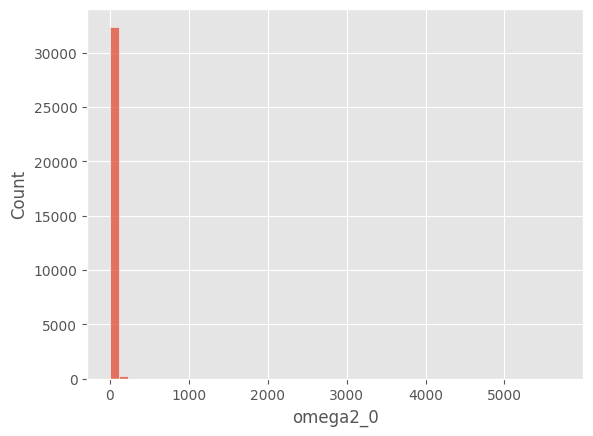

In [204]:
# ver distribución de columna omega2_0
sns.histplot(kg_data['omega2_0'], bins=50)

In [205]:
# Ver porcentaje de valores mayores a un threshold
#threshold = 10
#print(f'Porcentaje de valores mayores a {threshold}: {np.sum(kg_data["omega2_9"] > threshold) * 100 / kg_data.shape[0] }%')

# quitar valores mayores a threshold
#for i in range(29):
#    kg_data = kg_data[kg_data[f'omega2_{i}'] <= threshold]


In [206]:
X_train= kg_data.drop(['K', 'G'], axis=1)
y_train = kg_data['K']
#X_train

In [207]:
omega_columns = [col for col in X_train.columns if col.startswith('omega2_')]

is_increasing = X_train[omega_columns].apply(lambda row: row.dropna().is_monotonic_increasing, axis=1)

is_increasing.value_counts()

True    32768
Name: count, dtype: int64

In [208]:
import matplotlib.pyplot as plt

# Filtrar sólo las columnas 'omega2_'
omega_df_train = X_train[omega_columns]

sampled_omega_df_train = omega_df_train.sample(n=1000, random_state=42)  # Cambia el número de muestras según sea necesario


graficar = False

if graficar:
    # Graficar los valores de cada fila
    plt.figure(figsize=(10, 6))
    for i, row in sampled_omega_df_train.iterrows():
        plt.plot(row.index, row.values, marker='o', label=f'Row {i}')

    plt.xlabel('Omega Columns')
    plt.ylabel('Values')
    plt.title('Omega Values for Each Row')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [209]:
sampled_rows_list = sampled_omega_df_train.values.tolist()


# Test

In [210]:
kg_exp = pd.read_csv('KG_Experimental_Iso_new.csv')
#kg_exp

In [225]:
kg_exp.describe()

,K,G,rho,dx,dy,dz,omega2_0,omega2_1,omega2_2,omega2_3,...,omega2_19,omega2_20,omega2_21,omega2_22,omega2_23,omega2_24,omega2_25,omega2_26,omega2_27,omega2_28
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000
mean,1.403286,0.623800,8.236714,0.483467,0.356296,0.375323,3.963986,6.420335,8.640703,10.607832,...,18.133860,21.347233,24.647038,22.644804,25.922900,7.853597,7.775047,8.293052,8.453008,8.641548
std,0.281983,0.139766,1.350452,0.220674,0.181649,0.223671,3.397599,6.184971,7.257131,9.436491,...,21.335634,31.043256,29.632569,33.210813,31.633024,0.822287,NaN,NaN,NaN,NaN
min,1.000000,0.380700,5.403000,0.234800,0.191400,0.145530,1.320706,0.000000,2.722901,2.909486,...,6.875600,0.000000,7.094259,0.000000,7.240164,7.272152,7.775047,8.293052,8.453008,8.641548
25%,1.230500,0.563250,8.228500,0.285895,0.206470,0.151660,1.377391,2.342867,2.812201,2.941102,...,7.517801,3.541409,7.540607,3.582411,7.661183,7.562875,7.775047,8.293052,8.453008,8.641548
50%,1.317000,0.615100,8.460000,0.463190,0.260230,0.388640,1.485197,2.452166,3.498974,3.897721,...,7.764362,7.082817,7.986955,7.164823,8.082202,7.853597,7.775047,8.293052,8.453008,8.641548
75%,1.677000,0.744200,8.968000,0.703200,0.499250,0.593035,6.839749,11.587719,15.433432,19.666043,...,18.380422,32.020850,33.423428,33.967206,35.264268,8.144320,7.775047,8.293052,8.453008,8.641548
max,1.691000,0.755900,9.401000,0.708090,0.631000,0.603700,8.507717,14.629007,17.771782,22.233325,...,50.131116,56.958882,58.859900,60.769589,62.446335,8.435042,7.775047,8.293052,8.453008,8.641548


In [212]:
X_test

[[nan, 2], [6, nan], [nan, 6]]

In [213]:
X_test= kg_exp.drop(['K', 'G'], axis=1)
y_test = kg_exp['K']
#X_test

In [214]:
df_first_10_columns = X_test.iloc[:, :14]
#df_first_10_columns

In [215]:
omega_columns = [col for col in X_test.columns if col.startswith('omega2_')]

is_increasing = X_test[omega_columns].apply(lambda row: row.dropna().is_monotonic_increasing, axis=1)

#is_increasing

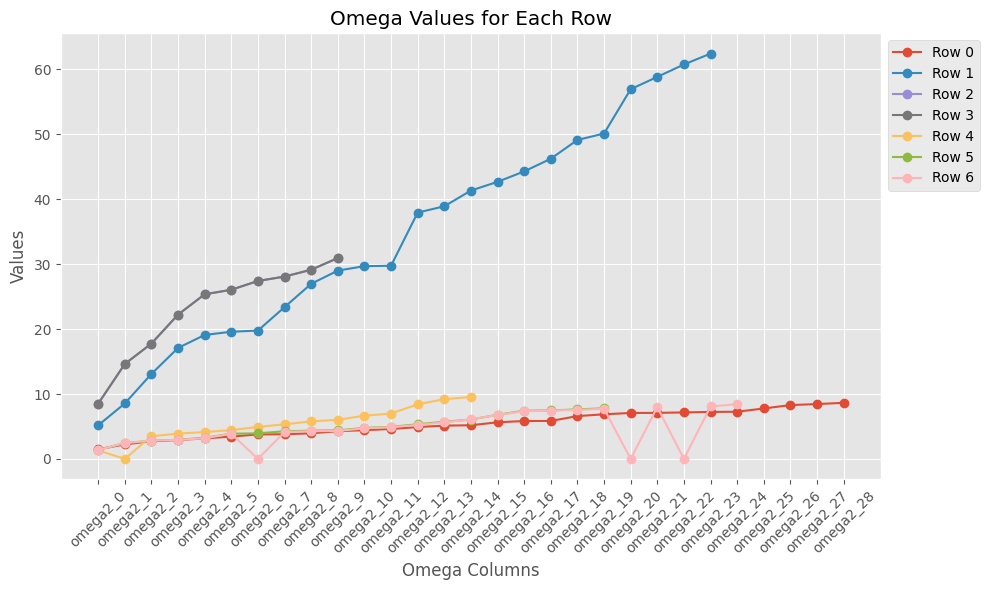

In [216]:
import matplotlib.pyplot as plt

# Filtrar sólo las columnas 'omega2_'
omega_df = X_test[omega_columns]

# Graficar los valores de cada fila
plt.figure(figsize=(10, 6))
for i, row in omega_df.iterrows():
    plt.plot(row.index, row.values, marker='o', label=f'Row {i}')

plt.xlabel('Omega Columns')
plt.ylabel('Values')
plt.title('Omega Values for Each Row')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


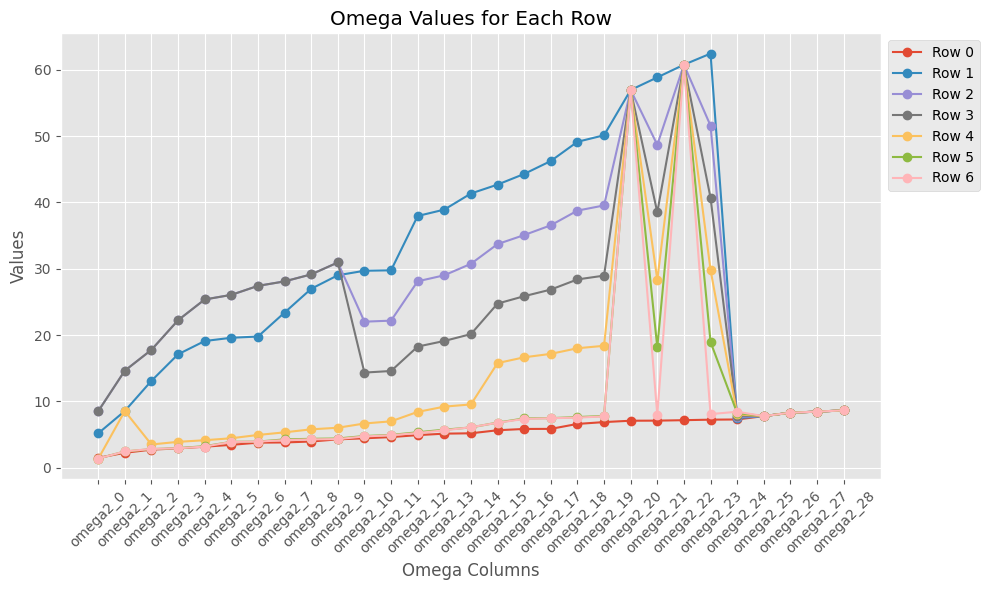

In [217]:
omega_dff = omega_df.copy()
omega_dff = omega_dff.replace(0.0, np.nan)
omega_dff.interpolate(method='linear', axis=0, inplace=True)  # Interpolación por filas



# Graficar los valores de cada fila
plt.figure(figsize=(10, 6))
for i, row in omega_dff.iterrows():
    plt.plot(row.index, row.values, marker='o', label=f'Row {i}')

plt.xlabel('Omega Columns')
plt.ylabel('Values')
plt.title('Omega Values for Each Row')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

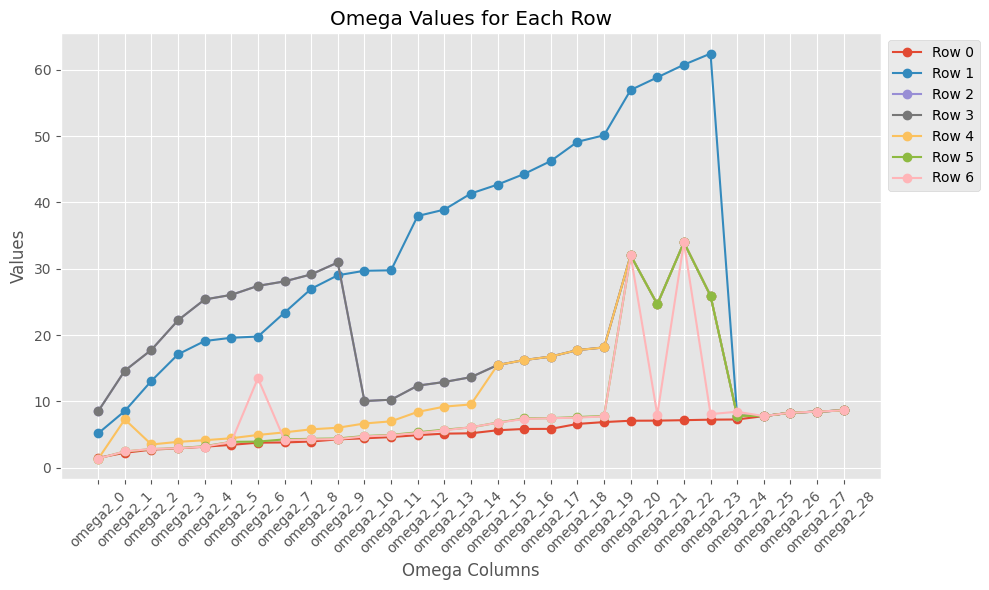

In [218]:
from sklearn.impute import KNNImputer

omega_dfff = omega_df.copy()
# Reemplazar ceros con NaN y aplicar el KNN Imputer
omega_dfff = omega_dfff.replace(0.0, np.nan)
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(omega_dfff), columns=omega_dfff.columns)

# Graficar los valores de cada fila
plt.figure(figsize=(10, 6))
for i, row in df_imputed.iterrows():
    plt.plot(row.index, row.values, marker='o', label=f'Row {i}')

plt.xlabel('Omega Columns')
plt.ylabel('Values')
plt.title('Omega Values for Each Row')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

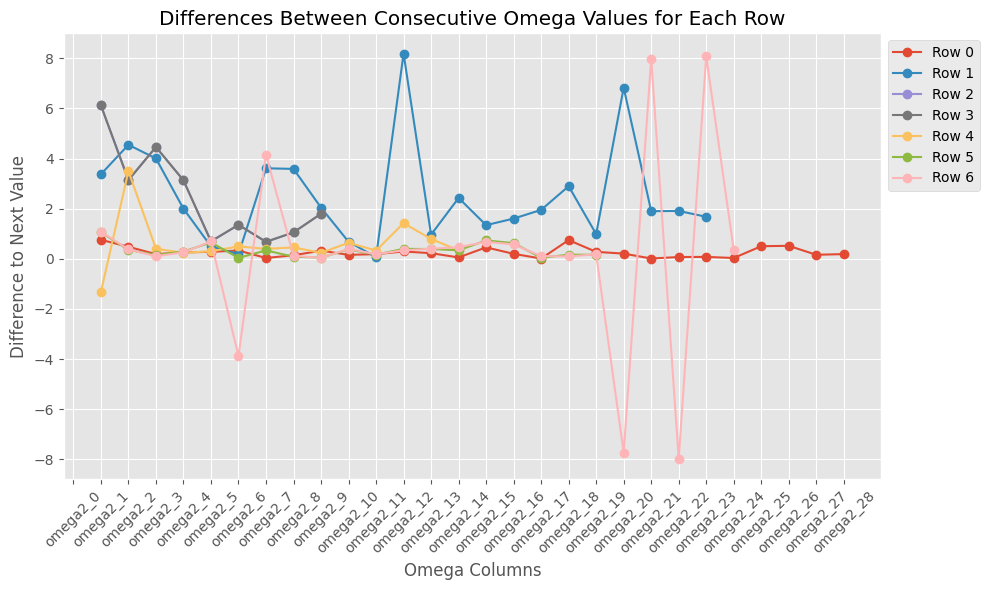

In [219]:
# Calcular la diferencia entre valores consecutivos en cada fila para las columnas 'omega2_'
omega_diff_df = omega_df.diff(axis=1)

# Graficar las diferencias de cada fila
plt.figure(figsize=(10, 6))
for i, row in omega_diff_df.iterrows():
    plt.plot(row.index, row.values, marker='o', label=f'Row {i}')

plt.xlabel('Omega Columns')
plt.ylabel('Difference to Next Value')
plt.title('Differences Between Consecutive Omega Values for Each Row')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [220]:
omega_df_nan = omega_df.replace(0.0, np.nan)
omega_df_rows_list = omega_df_nan.values.tolist()

# Imputer

In [221]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit(sampled_rows_list)

#X_test = [[np.nan, 2], [6, np.nan], [np.nan, 4]]

# the model learns that the second feature is double the first

result = (imp.transform(omega_df_rows_list))
print(result)


[[  1.48519708   2.24345615   2.7229011    2.90948566   3.16277023
    3.44288032   3.77183014   3.80516804   3.94607505   4.27214439
    4.43025381   4.61636557   4.90788967   5.13261769   5.18693805
    5.64331168   5.84138793   5.85250923   6.59843589   6.8756003
    7.08281701   7.09425933   7.16482258   7.24016386   7.27215243
    7.7750469    8.29305244   8.45300832   8.64154846]
 [  5.17178069   8.54643065  13.09508098  17.09876075  19.09898126
   19.59365997  19.77513663  23.38742442  26.9756274   29.01762457
   29.69774448  29.76619664  37.95570644  38.91910862  41.34762435
   42.6908243   44.2960379   46.24738218  49.14484368  50.13111577
   56.95888239  58.85989989  60.76958917  62.44633468  99.59033542
  140.40342447 148.40066442 178.38134313 177.71677819]
 [  8.50771718  14.62900726  17.77178249  22.23332508  25.36526449
   26.06198827  27.41679601  28.09384982  29.14801115  30.94543468
   38.23501269  46.62550704  56.83438549  58.21256777  69.58647869
   71.9960518   77.4

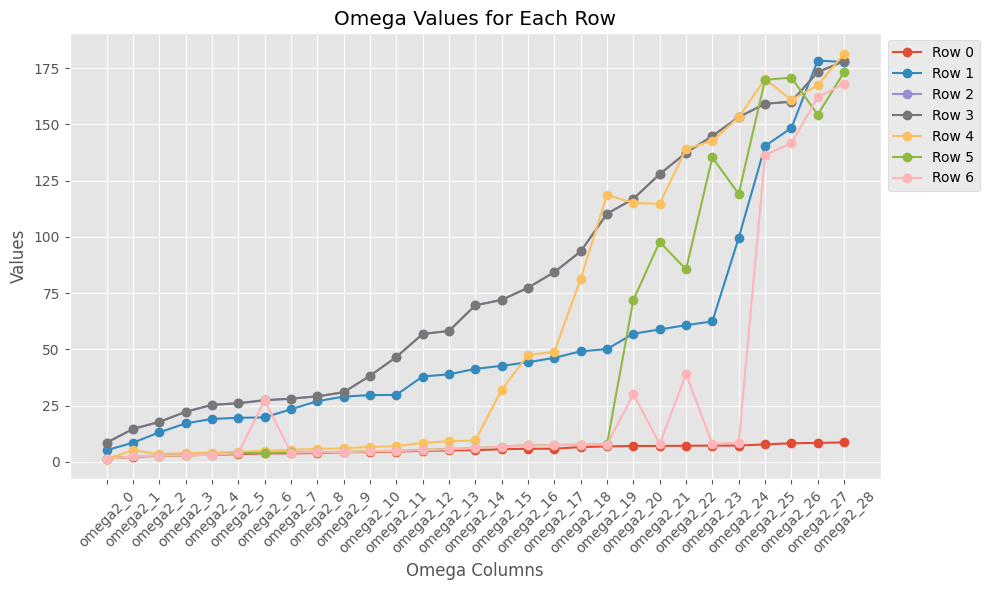

In [222]:
import matplotlib.pyplot as plt

omega_columns_sample = [f'omega2_{i}' for i in range(len(result[0]))]

# Crear el DataFrame con estos datos y los índices de columnas

df_sample = pd.DataFrame(result, columns=omega_columns_sample)


# Graficar los valores de cada fila
plt.figure(figsize=(10, 6))
for i, row in df_sample.iterrows():
    plt.plot(row.index, row.values, marker='o', label=f'Row {i}')

plt.xlabel('Omega Columns')
plt.ylabel('Values')
plt.title('Omega Values for Each Row')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


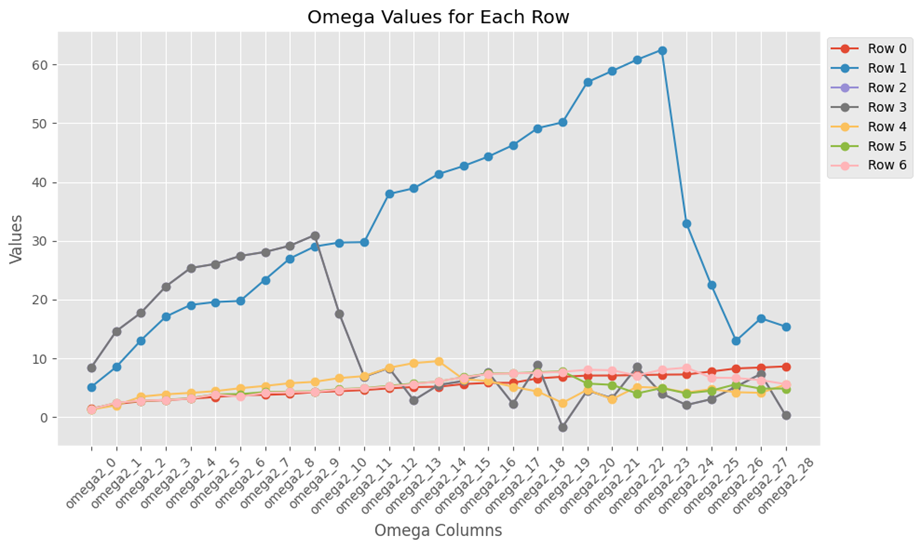

<Axes: xlabel='omega2_0', ylabel='Count'>

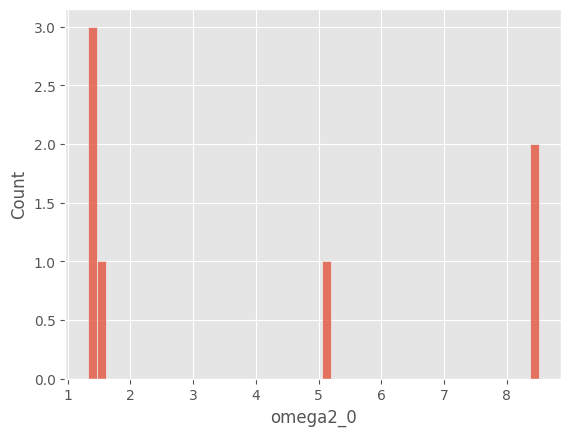

In [223]:
sns.histplot(kg_exp['omega2_0'], bins=50)

# Multicollinearity

In [226]:
X_train

,rho,dx,dy,dz,omega2_0,omega2_1,omega2_2,omega2_3,omega2_4,omega2_5,...,omega2_19,omega2_20,omega2_21,omega2_22,omega2_23,omega2_24,omega2_25,omega2_26,omega2_27,omega2_28
98304,0.2,0.1,0.1,0.1,305.949932,305.949932,538.737936,538.737936,538.737936,569.329111,...,1046.087643,1097.826732,1112.716168,1112.716168,1112.716168,1141.302791,1141.302791,1141.302791,1398.706432,1398.706432
98305,0.2,0.1,0.1,0.1,1075.314226,1075.314226,1075.314226,1076.154837,1076.154837,1207.239186,...,2608.401583,2986.764319,3022.281292,3022.281292,3022.281292,3678.799701,3678.799701,3678.799701,3848.625757,3848.625757
98306,0.2,0.1,0.1,0.1,1210.689633,1210.689633,1210.689633,1249.625344,1844.876865,1844.876865,...,4476.571951,4476.581095,4717.597715,4717.597715,4717.597715,4895.536301,4895.536301,4895.536301,5894.626541,5894.626541
98307,0.2,0.1,0.1,0.1,1270.795971,1278.305535,1278.305535,1278.305535,2274.177505,2274.177505,...,5780.261851,5780.261851,6344.747638,6344.747638,6344.760607,6424.710633,6424.710633,6424.710633,7234.147640,7234.147640
98308,0.2,0.1,0.1,0.1,1283.817154,1319.898025,1319.898025,1319.898025,2503.858432,2503.858432,...,6512.859053,6512.859053,8144.613603,8144.613603,8144.613603,8212.923324,8212.923324,8212.940118,8460.098273,8460.098273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131067,10.0,1.0,1.0,1.0,0.524843,0.524843,0.951233,0.951233,0.951233,0.984598,...,1.958139,1.964823,1.964823,1.964823,2.055156,2.055156,2.055156,2.483749,2.483749,2.483749
131068,10.0,1.0,1.0,1.0,0.679250,0.679250,1.222681,1.222681,1.222681,1.271930,...,2.511279,2.540864,2.540864,2.540864,2.614330,2.614330,2.614330,3.178955,3.178955,3.178955
131069,10.0,1.0,1.0,1.0,0.833611,0.833611,1.489930,1.489930,1.489930,1.557945,...,3.052754,3.115621,3.115621,3.115621,3.150207,3.150207,3.150207,3.664524,3.865323,3.865323
131070,10.0,1.0,1.0,1.0,0.987931,0.987931,1.752842,1.752842,1.752842,1.842519,...,3.582018,3.663105,3.663105,3.663105,3.688993,3.688993,3.688993,3.802154,4.545640,4.545640


In [230]:
df = X_train.copy()
X = X_train.copy()


In [228]:
import pandas as pd

# Calcular la matriz de correlación
corr_matrix = df.corr().abs()

# Identificar variables con alta correlación (e.g., umbral de 0.8)
high_corr_var = [
    (col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns
    if col1 != col2 and corr_matrix.loc[col1, col2] > 0.8
]
print("Pairs of highly correlated variables:", high_corr_var)


Pairs of highly correlated variables: [('omega2_0', 'omega2_1'), ('omega2_0', 'omega2_2'), ('omega2_0', 'omega2_3'), ('omega2_0', 'omega2_4'), ('omega2_0', 'omega2_5'), ('omega2_0', 'omega2_6'), ('omega2_0', 'omega2_7'), ('omega2_0', 'omega2_8'), ('omega2_0', 'omega2_9'), ('omega2_0', 'omega2_10'), ('omega2_0', 'omega2_11'), ('omega2_0', 'omega2_12'), ('omega2_1', 'omega2_0'), ('omega2_1', 'omega2_2'), ('omega2_1', 'omega2_3'), ('omega2_1', 'omega2_4'), ('omega2_1', 'omega2_5'), ('omega2_1', 'omega2_6'), ('omega2_1', 'omega2_7'), ('omega2_1', 'omega2_8'), ('omega2_1', 'omega2_9'), ('omega2_1', 'omega2_10'), ('omega2_1', 'omega2_11'), ('omega2_1', 'omega2_12'), ('omega2_2', 'omega2_0'), ('omega2_2', 'omega2_1'), ('omega2_2', 'omega2_3'), ('omega2_2', 'omega2_4'), ('omega2_2', 'omega2_5'), ('omega2_2', 'omega2_6'), ('omega2_2', 'omega2_7'), ('omega2_2', 'omega2_8'), ('omega2_2', 'omega2_9'), ('omega2_2', 'omega2_10'), ('omega2_2', 'omega2_11'), ('omega2_2', 'omega2_12'), ('omega2_3', 'om

In [231]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filtrar variables con VIF alto (e.g., mayor a 10)
high_vif = vif_data[vif_data["VIF"] > 10]
print("Features with high VIF:", high_vif)


Features with high VIF:       feature          VIF
4    omega2_0  2634.243752
5    omega2_1  3416.148687
6    omega2_2  1658.944881
7    omega2_3  3084.050362
8    omega2_4  1268.887398
9    omega2_5  1137.663946
10   omega2_6  1689.549226
11   omega2_7  2093.211313
12   omega2_8  2343.550618
13   omega2_9  2150.095071
14  omega2_10  1198.019875
15  omega2_11  1721.589573
16  omega2_12  3359.155002
17  omega2_13  2300.139947
18  omega2_14  2967.382640
19  omega2_15  5431.805942
20  omega2_16  3120.221789
21  omega2_17  2160.474996
22  omega2_18  1595.331199
23  omega2_19  1234.264207
24  omega2_20  1607.149704
25  omega2_21  2242.133620
26  omega2_22  2308.570427
27  omega2_23  3808.338464
28  omega2_24  5043.273737
29  omega2_25  5101.776899
30  omega2_26  3576.451026
31  omega2_27  2290.047044
32  omega2_28  2075.644719


In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, threshold=10):
    variables = df.copy()
    high_vif_features = []

    while True:
        vif_data = pd.DataFrame()
        vif_data["feature"] = variables.columns
        vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

        max_vif = vif_data["VIF"].max()
        max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]

        if max_vif > threshold:
            print(f"Removing '{max_vif_feature}' with VIF={max_vif}")
            high_vif_features.append(max_vif_feature)
            variables.drop(columns=[max_vif_feature], inplace=True)
        else:
            break

    print("Final features with acceptable VIF:\n", variables.columns.tolist())
    return variables, high_vif_features

X_reduced, removed_features = calculate_vif(X, threshold=10)


Removing 'omega2_15' with VIF=5431.805942124078
Removing 'omega2_25' with VIF=4956.979327731241
Removing 'omega2_24' with VIF=4532.705928297877
Removing 'omega2_1' with VIF=3139.299576143798
Removing 'omega2_23' with VIF=2657.979551395774
Removing 'omega2_12' with VIF=2212.0255608259513
Removing 'omega2_8' with VIF=2087.5228867121505
Removing 'omega2_27' with VIF=1951.6277377978968
Removing 'omega2_14' with VIF=1630.9215387914182
Removing 'omega2_7' with VIF=1508.6699702873689
Removing 'omega2_3' with VIF=1460.6250444075297
Removing 'omega2_22' with VIF=1282.9037304028516
Removing 'omega2_16' with VIF=1216.7984781791179
Removing 'omega2_20' with VIF=970.3185074363516
Removing 'omega2_17' with VIF=952.3736107721552
Removing 'omega2_11' with VIF=716.3492967848497
Removing 'omega2_9' with VIF=602.6048217170004
Removing 'omega2_6' with VIF=492.76413267732806
Removing 'omega2_18' with VIF=419.0703592430044
Removing 'omega2_4' with VIF=380.7841623081611
Removing 'omega2_21' with VIF=328.2228